In [1]:
import pandas as pd
from auto_ml_regression.preprocessing import DataPreprocessor

data = pd.read_csv('../../datasets/coffee_shop_dataset/coffee_shop_revenue.csv')
target_col="Daily_Revenue"
N_SEGMENTS = 2
# cols_to_del = ['Country']
# data = data.drop(columns=cols_to_del).dropna(subset=target_col)

cat_features = data.select_dtypes(include='object').columns.to_list()
num_features = data.select_dtypes(exclude='object').columns.to_list()
num_features.remove(target_col)
cat_features_saved = [f'CAT_{i}' for i in cat_features]

# Инициализация и применение препроцессора
preprocessor = DataPreprocessor(
    target_col=target_col,
    cat_encoder_type="target",  # или "ohe"
    fillna_num_strategy="mean",
    scaler_type="minmax",
    test_size=0.3,
    random_state=2025,
)

train_df, test_df = preprocessor.fit_transform(data)

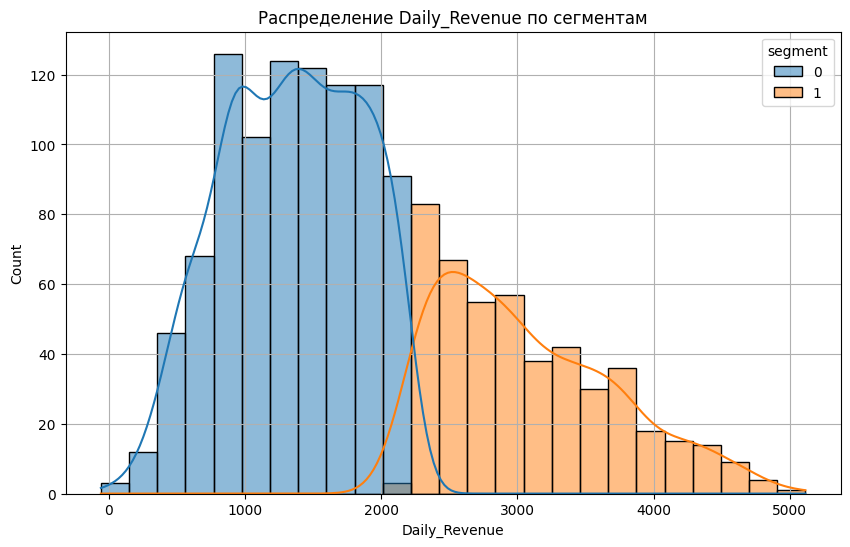

In [2]:
from auto_ml_regression.segmentation.kmeans import KMeansSegmenter

segmenter = KMeansSegmenter(N_SEGMENTS, plot=True)
segmented_train = segmenter.fit(train_df.copy(), target_col)

In [3]:
from auto_ml_regression.modeling.classifier import SegmentClassifier
from sklearn import metrics
import numpy as np

# ohe_cat_cols = list(set(segmented_train.columns) - set(num_features) - set(cat_features_saved) - set([target_col]))
# 2. Инициализация и обучение классификатора сегментов
clf = SegmentClassifier(
    features=num_features+cat_features_saved,
    cat_features=cat_features_saved, 
    n_segments=N_SEGMENTS
)

# Обучаем на сегментированных данных
clf.fit(
    X=segmented_train[num_features+cat_features_saved],
    y=segmented_train['segment'],
    n_trials=30  # Количество итераций Optuna
)


/Users/andrejurkinair/Documents/diploma_practice/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-05-20 23:37:00,632] A new study created in memory with name: no-name-8a5f69dc-c326-4abd-9abc-878bce8506d1
[I 2025-05-20 23:37:00,825] Trial 0 finished with value: 0.9687714481811943 and parameters: {'iterations': 995, 'learning_rate': 0.002068533147649333, 'l2_leaf_reg': 0.002180794151667908, 'random_strength': 0.004277106855978767, 'bagging_temperature': 1.163425470828574, 'border_count': 130, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 5, 'grow_policy': 'Depthwise', 'od_type': 'Iter', 'od_wait': 40, 'one_hot_max_size': 87, 'max_depth': 9}. Best is trial 0 with value: 0.9687714481811943.
[I 2025-05-20 23:37:00,894] Trial 1 finished with value: 0.9770647449096317 and parameters: {'ite

Classification Report: TRAIN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       928
           1       1.00      1.00      1.00       472

    accuracy                           1.00      1400
   macro avg       1.00      1.00      1.00      1400
weighted avg       1.00      1.00      1.00      1400

ROC AUC = 1.0


In [5]:
# 3. Предсказание на тестовых данных
# Сначала сегментируем тестовые данные (используем тот же segmenter)
segmented_test = segmenter.predict(test_df, target_col=target_col)
# Предсказание сегментов
test_segment_probs = clf.model.predict_proba(segmented_test[num_features+cat_features_saved])
test_segments = clf.model.predict(segmented_test[num_features+cat_features_saved])
segmented_test['segment_probs'] = test_segment_probs[:, 1]
segmented_test['segment_preds'] = test_segments 

print(f"TEST ROC AUC - {metrics.roc_auc_score(segmented_test['segment'], test_segment_probs[:, 1], multi_class='ovr')}")#[:, 1]


TEST ROC AUC - 0.9858562836340614


In [6]:
from auto_ml_regression.modeling.linear_regs import SegmentLinearModels

lr = SegmentLinearModels(features=num_features+cat_features,
                         model_type='huber',
                         use_optuna=True,
                         n_trials=30,
                         cv=4)
lr.fit(segmented_train, 
       segmented_train[target_col], 
       segments=segmented_train['segment'])

[I 2025-05-20 23:40:30,587] A new study created in memory with name: no-name-27d01ce2-eb9e-4d06-8e22-d3b90b25e14a
[I 2025-05-20 23:40:30,633] Trial 0 finished with value: -449.21233951429764 and parameters: {'epsilon': 5.915843359493723, 'alpha': 0.09757113114305323, 'fit_intercept': False}. Best is trial 0 with value: -449.21233951429764.
[I 2025-05-20 23:40:30,662] Trial 1 finished with value: -512.2249496560246 and parameters: {'epsilon': 8.65054892203922, 'alpha': 0.07318108267951047, 'fit_intercept': True}. Best is trial 0 with value: -449.21233951429764.
[I 2025-05-20 23:40:30,683] Trial 2 finished with value: -551.813843079003 and parameters: {'epsilon': 1.1258138397694264, 'alpha': 0.12291936957276257, 'fit_intercept': True}. Best is trial 0 with value: -449.21233951429764.
[I 2025-05-20 23:40:30,703] Trial 3 finished with value: -898.5173224385171 and parameters: {'epsilon': 4.632882319840247, 'alpha': 0.2754359256998945, 'fit_intercept': False}. Best is trial 0 with value: -4

In [7]:
test_target_preds = lr.predict(segmented_test, 
                              segments=segmented_test['segment_preds']
                              )
                              # use_weighted=True,
                              # segment_probs=test_segment_probs

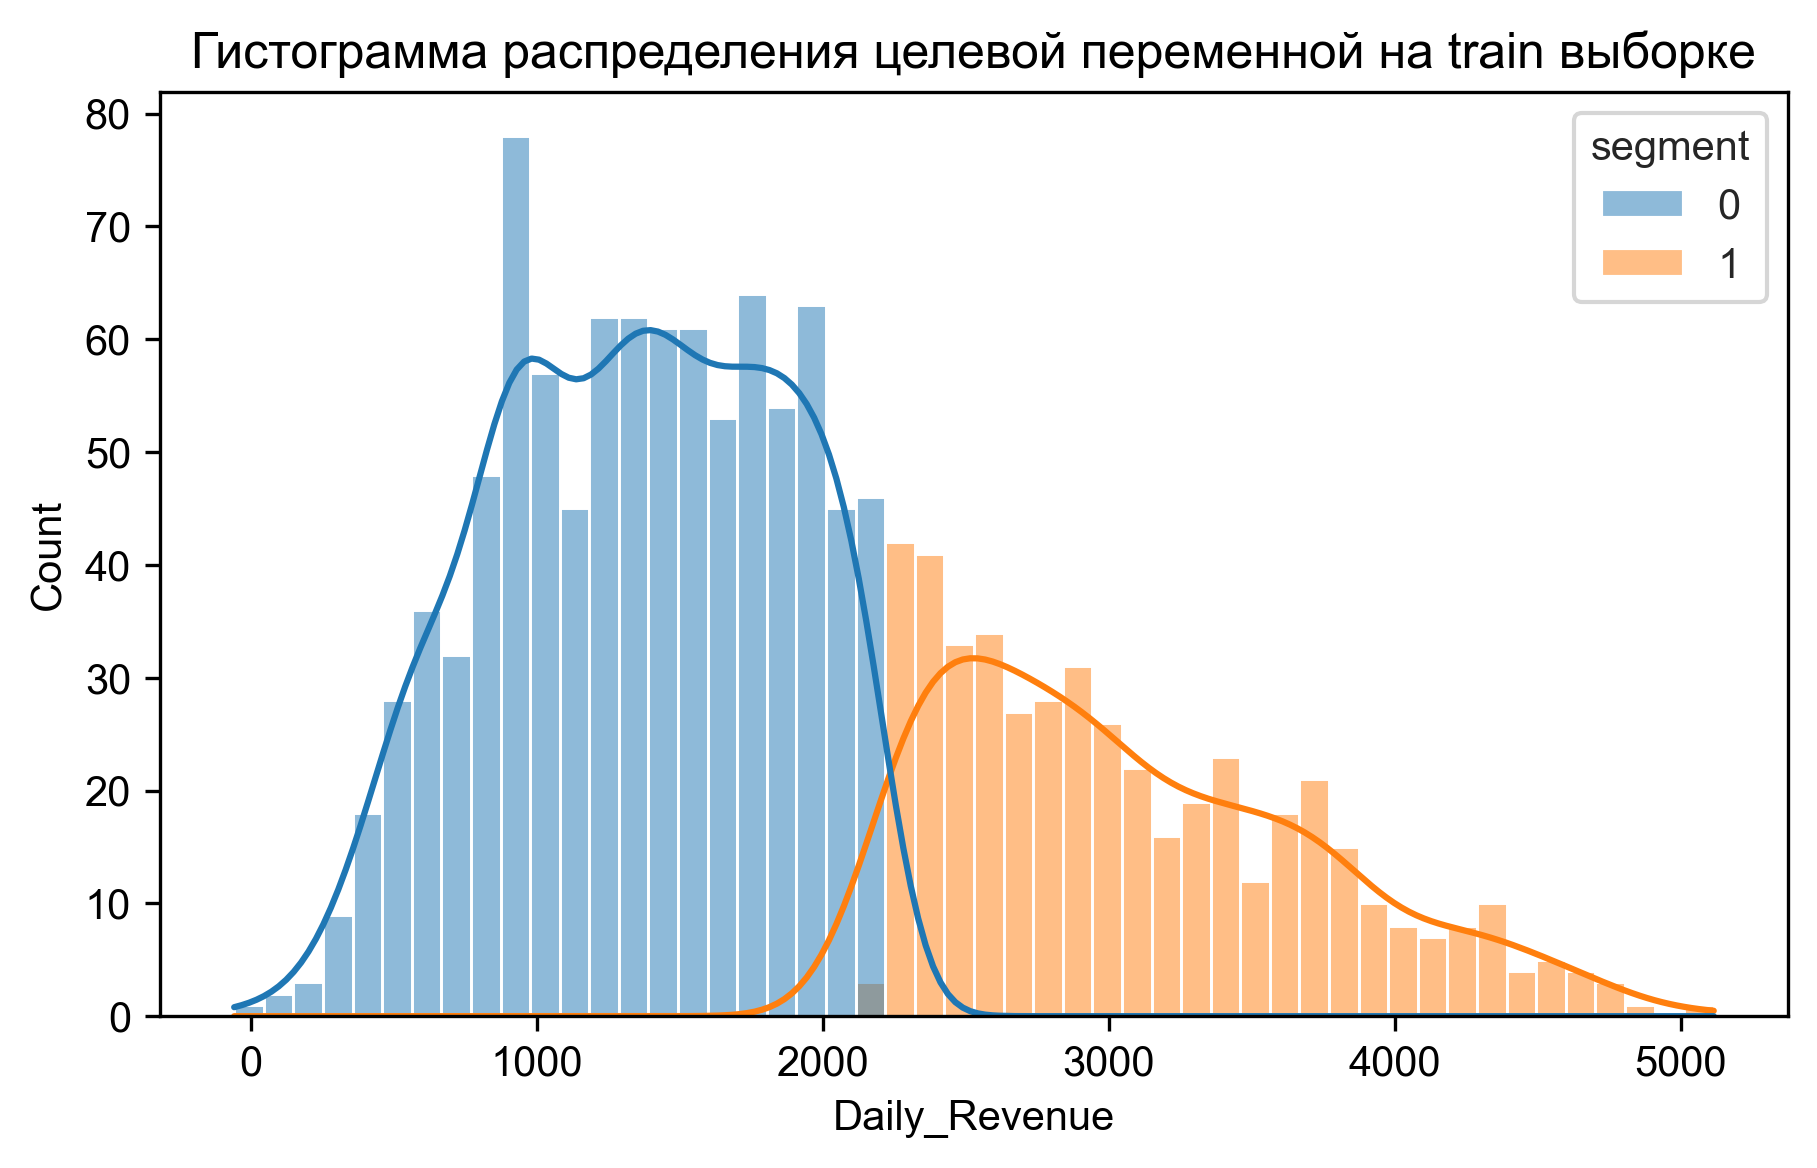

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,4), dpi=300)
plt.title("Гистограмма распределения целевой переменной на train выборке")
sns.set_style("whitegrid")
sns.histplot(segmented_train, x=target_col, hue='segment', bins=50, kde=True)
plt.show();

In [9]:
test_target_true = segmented_test[target_col]

In [10]:
r2 = metrics.r2_score(test_target_true, test_target_preds)
mse = metrics.mean_squared_error(test_target_true, test_target_preds)
mae = metrics.mean_absolute_error(test_target_true, test_target_preds)
mape = metrics.mean_absolute_percentage_error(test_target_true, test_target_preds)

print(f"R2 = {r2}")
print(f"MSE = {mse}")
print(f"RMSE = {mse**0.5}")
print(f"MAE = {mae}")
print(f"MAPE = {mape}")

R2 = 0.9157292132880189
MSE = 75474.58346404858
RMSE = 274.7263792649854
MAE = 219.87901334646992
MAPE = 0.15149006469321405


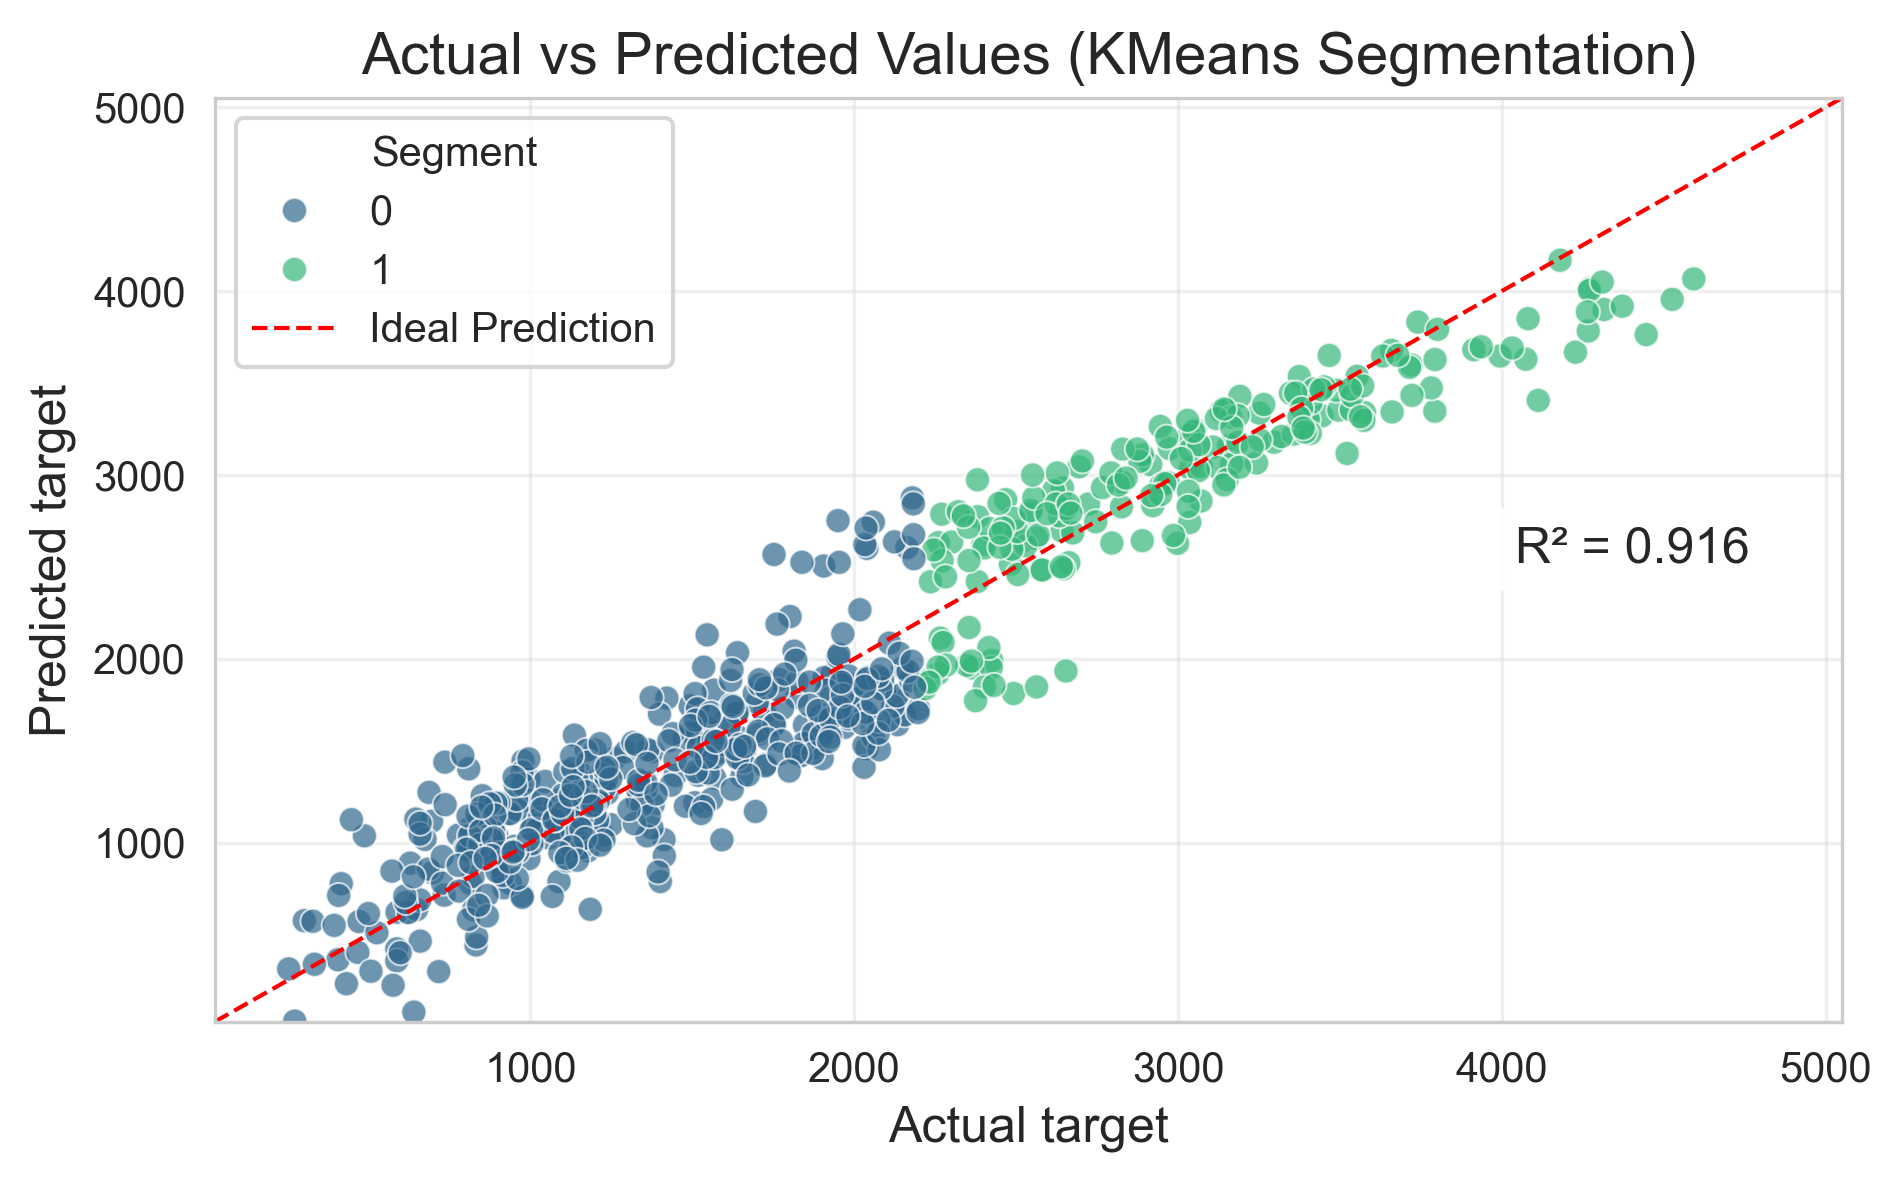

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

# Предположим, у нас есть:
# y_test - истинные значения на тестовой выборке
# y_pred - предсказания модели CatBoost+KMeans на тестовой выборке
y_test = test_target_true
y_pred = test_target_preds

# Создаем DataFrame для визуализации
plot_data = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Segment': segmented_test['segment']  # Добавляем информацию о сегментах
})

# Определяем границы осей (минимальное/максимальное значение + 10%)
ax_min = min(y_test.min(), y_pred.min()) * 0.9
ax_max = max(y_test.max(), y_pred.max()) * 1.1

# Создаем фигуру
plt.figure(figsize=(7, 4), dpi=300)

# Диаграмма рассеяния с цветовым кодированием по сегментам
scatter = sns.scatterplot(
    data=plot_data,
    x='Actual',
    y='Predicted',
    hue='Segment',
    palette='viridis',
    alpha=0.7
)

# Добавляем идеальную линию
ideal_line = plt.plot(
    [ax_min, ax_max],
    [ax_min, ax_max],
    '--',
    color='red',
    linewidth=1,
    label='Ideal Prediction'
)

# Настройки графика
plt.title('Actual vs Predicted Values (KMeans Segmentation)', fontsize=14)
plt.xlabel('Actual target', fontsize=12)
plt.ylabel('Predicted target', fontsize=12)
plt.xlim(ax_min, ax_max)
plt.ylim(ax_min, ax_max)
plt.legend(title='Segment')
plt.grid(True, alpha=0.3)

# Добавляем коэффициент R² в аннотацию
r2 = metrics.r2_score(y_test, y_pred)
plt.text(
    x=ax_max*0.8,
    y=ax_max*0.5,
    s=f'R² = {r2:.3f}',
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.show()